In [ ]:
import numpy as np
import pandas as np
import yfinance as yf
import matplotlib.pyplot as plt

# Parameters
start_date = '2015-01-01'
end_date = None

tickers = {
    "5Y":"^FVX",
    "10Y":"^TNX",
    "30Y":"^TYX"
}

# Data downloading
data = yf.download(
    list(tickers.values()),
    start=start_date,
    end=end_date,
    auto_adjust=True,
    progress=False
)["Close"]

data.columns = tickers.keys()

yields=data.dropna().copy()

print(yields.tail())

               5Y    10Y    30Y
Date                           
2025-12-19  3.693  4.151  4.828
2025-12-22  3.718  4.169  4.842
2025-12-23  3.734  4.169  4.831
2025-12-24  3.717  4.136  4.798
2025-12-26  3.692  4.120  4.794


In [ ]:
# Spreads construction in basis points
curve = yields.copy()
curve["10s5s_bps"] = (curve["10Y"] - curve["5Y"])*100
curve["30s10s_bps"] = (curve["30Y"] - curve["10Y"])*100

In [ ]:
for col in ["5Y","10Y","30Y"]:
  curve[f"{col}_chg_bps"] = curve[col].diff()*100

curve["level_chg_bps"] = curve["10Y"].diff() * 100 # Benchmark
curve["slope_chg_bps"] = curve["10s5s_bps"].diff()
curve = curve.dropna()

In [ ]:
# Regime classification

def classify_regime(level_chg, slope_chg):
    if level_chg < 0 and slope_chg > 0:
        return "Bull Steepening"
    if level_chg < 0 and slope_chg < 0:
        return "Bull Flattening"
    if level_chg > 0 and slope_chg > 0:
        return "Bear Steepening"
    if level_chg > 0 and slope_chg < 0:
        return "Bear Flattening"
    return "Neutral"

curve["regime"] = [
    classify_regime(lv, sl)
    for lv, sl in zip(curve["level_chg_bps"], curve["slope_chg_bps"])
]

print(curve[["level_chg_bps", "slope_chg_bps", "regime"]].tail(10))


            level_chg_bps  slope_chg_bps           regime
Date                                                     
2025-12-12       5.299997       1.699996  Bear Steepening
2025-12-15      -1.199961       0.600028  Bull Steepening
2025-12-16      -3.299999       0.699997  Bull Steepening
2025-12-17       0.199986       0.000000          Neutral
2025-12-18      -3.499985       0.000000          Neutral
2025-12-19       3.499985       0.199986  Bear Steepening
2025-12-22       1.800013      -0.699973  Bear Flattening
2025-12-23       0.000000      -1.600003          Neutral
2025-12-24      -3.299999      -1.600003  Bull Flattening
2025-12-26      -1.600027       0.899982  Bull Steepening


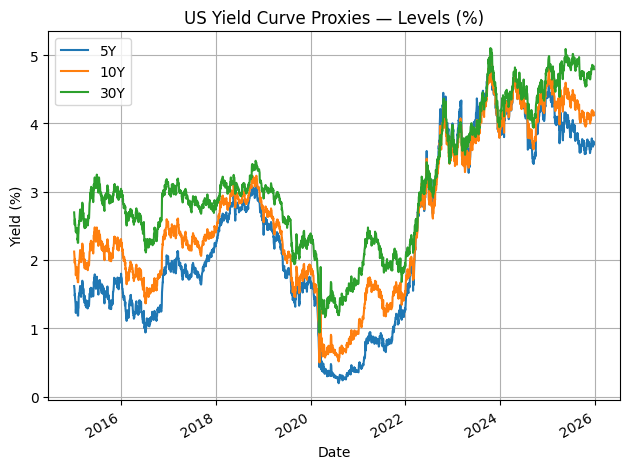

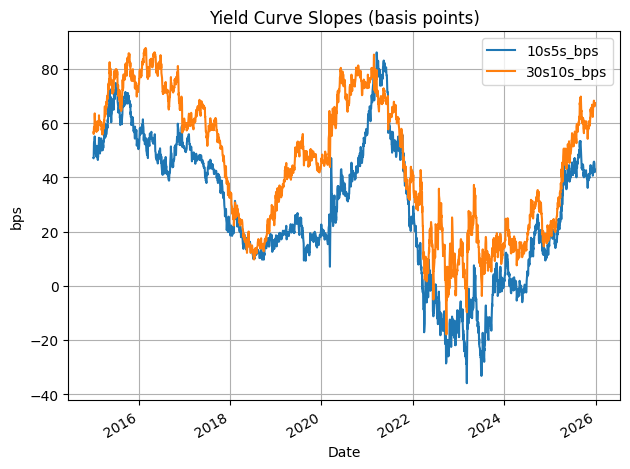

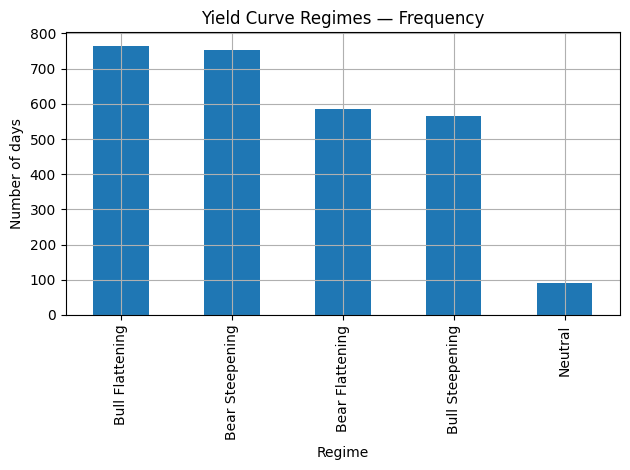

regime
Bull Flattening    765
Bear Steepening    754
Bear Flattening    585
Bull Steepening    565
Neutral             92
Name: count, dtype: int64


In [ ]:
yields.plot()
plt.title("US Yield Curve Proxies — Levels (%)")
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

curve[["10s5s_bps", "30s10s_bps"]].plot()
plt.title("Yield Curve Slopes (basis points)")
plt.xlabel("Date")
plt.ylabel("bps")
plt.grid(True)
plt.tight_layout()
plt.show()

regime_counts = curve["regime"].value_counts()

regime_counts.plot(kind="bar")
plt.title("Yield Curve Regimes — Frequency")
plt.xlabel("Regime")
plt.ylabel("Number of days")
plt.grid(True)
plt.tight_layout()
plt.show()

print(regime_counts)

